# Facial Emotion Recognition CNN-LSTM


In [10]:
pip install torchview

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
from torchsummary import summary
from graphviz import Digraph

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset, Dataloaders

In [14]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Facial-Emotion-Recognition/fer2013.csv"
df = pd.read_csv(data_path)

pixels = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=int))
labels = df['emotion']

pixels = torch.stack([torch.tensor(p) for p in pixels])
labels = torch.tensor(labels)

pixels = pixels.float() / 255.0

train_size = int(0.7 * len(pixels))
val_size = int(0.15 * len(pixels))
test_size = len(pixels) - train_size - val_size

train_pixels, val_pixels, test_pixels = pixels[:train_size], pixels[train_size:train_size+val_size], pixels[-test_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size+val_size], labels[-test_size:]

batch_size = 64
train_dataset = TensorDataset(train_pixels, train_labels)
val_dataset = TensorDataset(val_pixels, val_labels)
test_dataset = TensorDataset(test_pixels, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


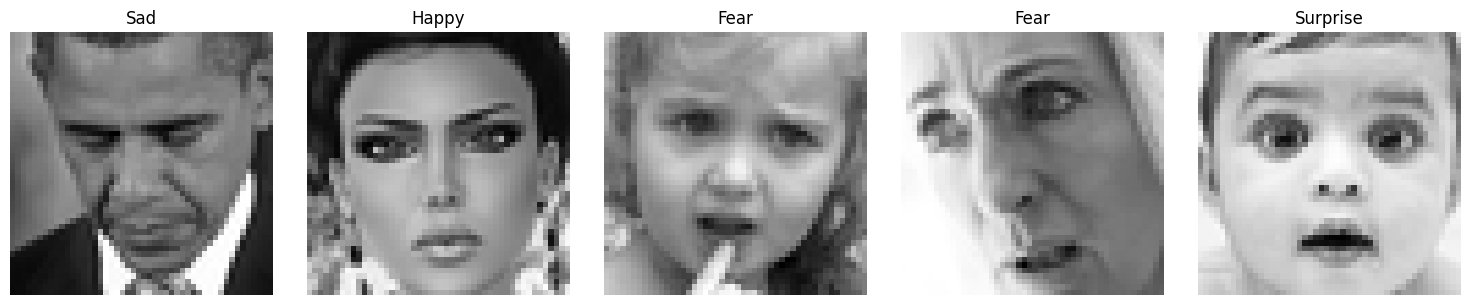

In [15]:
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

num_samples = 5

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    index = random.randint(0, len(train_pixels))

    image = train_pixels[index].view(48, 48).numpy()
    label = int(train_labels[index])
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(class_labels[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## CNN-LSTM Model

In [16]:
class CNNLSTMModel(nn.Module):
    def __init__(self, num_classes, num_lstm_units):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, num_lstm_units)
        self.lstm = nn.LSTM(input_size=num_lstm_units, hidden_size=num_lstm_units,
                            num_layers=2, batch_first=True, bidirectional=True)
        self.fc2 = nn.Linear(num_lstm_units * 2, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), 1, 48, 48)
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = x.unsqueeze(1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc2(x)
        return x

Total parameters in the model: 2211591
CNNLSTMModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)


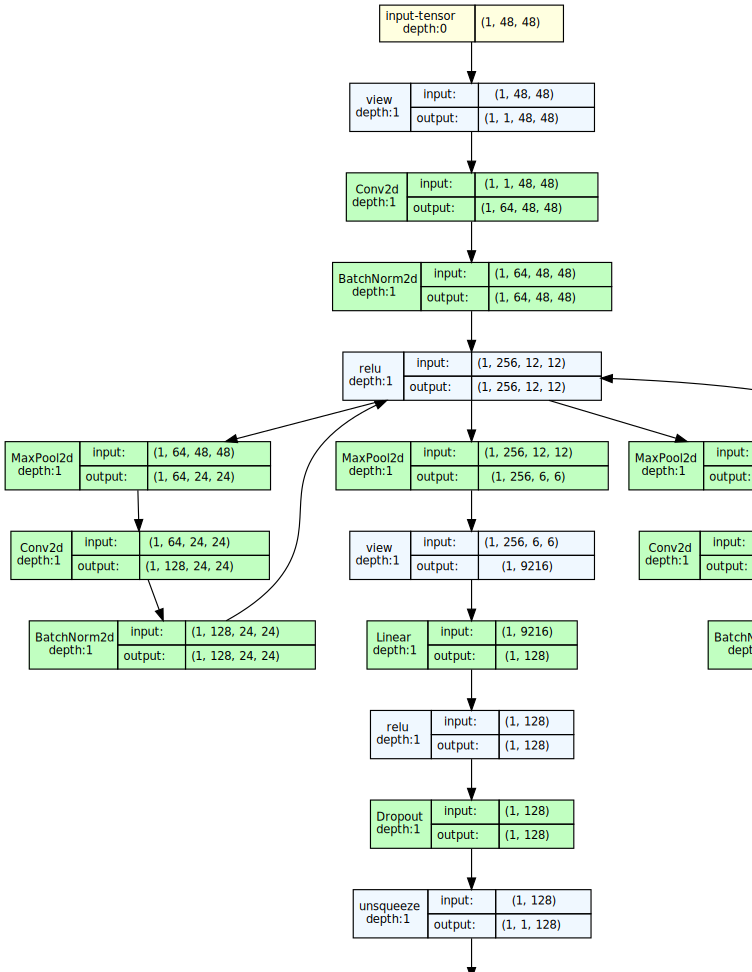

In [17]:
num_classes = 7  # Emotion classes in FER2013
num_lstm_units = 128
model = CNNLSTMModel(num_classes, num_lstm_units)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters in the model: {total_params}")

print(model)

from torchview import draw_graph
filename = '/content/drive/MyDrive/Colab Notebooks/Facial-Emotion-Recognition/architecture.png'
model_graph = draw_graph(model, input_size=(1, 48, 48), graph_dir='TB', roll=True, expand_nested=True, graph_name='arch', save_graph=True, filename=filename)
model_graph.visual_graph

## Train. Validation

Epoch 1/100, Training Loss: 1.7570, Training Accuracy: 27.87%
             Validation Accuracy: 26.16%
Epoch 2/100, Training Loss: 1.5959, Training Accuracy: 32.17%
             Validation Accuracy: 39.12%
Epoch 3/100, Training Loss: 1.4808, Training Accuracy: 35.59%
             Validation Accuracy: 45.57%
Epoch 4/100, Training Loss: 1.4052, Training Accuracy: 38.16%
             Validation Accuracy: 47.69%
Epoch 5/100, Training Loss: 1.3569, Training Accuracy: 40.09%
             Validation Accuracy: 50.62%
Epoch 6/100, Training Loss: 1.3075, Training Accuracy: 41.74%
             Validation Accuracy: 50.16%
Epoch 7/100, Training Loss: 1.2637, Training Accuracy: 43.19%
             Validation Accuracy: 51.77%
Epoch 8/100, Training Loss: 1.2278, Training Accuracy: 44.43%
             Validation Accuracy: 53.13%
Epoch 9/100, Training Loss: 1.1893, Training Accuracy: 45.57%
             Validation Accuracy: 54.67%
Epoch 10/100, Training Loss: 1.1568, Training Accuracy: 46.63%
          

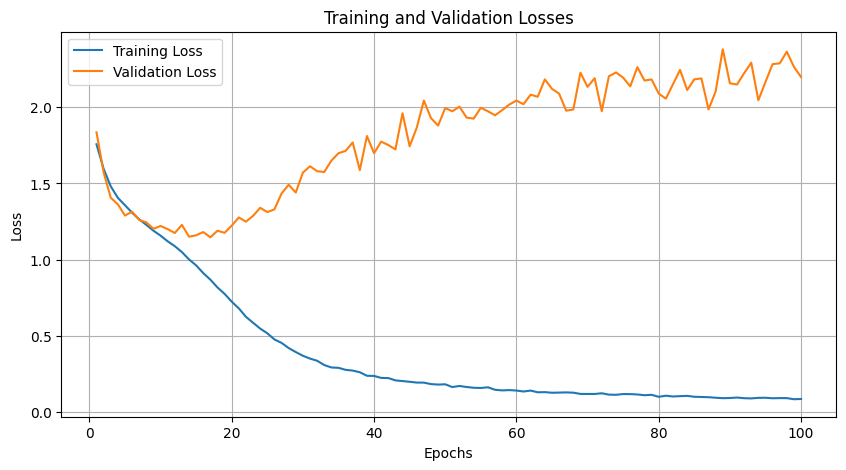

In [18]:
# Training loop
num_epochs = 100

train_losses = []
train_correct = 0
train_total = 0

val_losses = []
val_correct = 0
val_total = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct / total

    print(f"             Validation Accuracy: {val_accuracy:.2f}%")

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.grid(True)
plt.show()

In [19]:
# Test loop
test_losses = []
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 2.2254
Test Accuracy: 52.01%


In [20]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Facial-Emotion-Recognition/best100-v3.pth')

## Inference

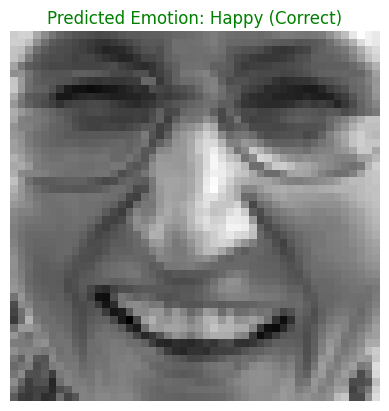

Execution stopped by user.


In [21]:
import random
import time
from IPython.display import clear_output

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

num_classes = 7
num_lstm_units = 128
model = CNNLSTMModel(num_classes, num_lstm_units)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Facial-Emotion-Recognition/best100-v3.pth'))
model.to(device)
model.eval()

try:
    while True:
        clear_output(wait=True)

        random_index = random.randint(0, len(val_pixels) - 1)
        random_image_pixels = val_pixels[random_index]
        random_image_pixels = random_image_pixels.view(1, 48, 48)

        random_image_tensor = random_image_pixels.to(device)

        model.eval()
        with torch.no_grad():
            output = model(random_image_tensor)
            _, predicted_label = torch.max(output, 1)

        correct_prediction = (predicted_label.item() == val_labels[random_index].item())

        plt.imshow(random_image_pixels.view(48, 48), cmap='gray')
        if correct_prediction:
            plt.title(f'Predicted Emotion: {emotion_labels[predicted_label.item()]} (Correct)', color='green')
        else:
            correct_label = emotion_labels[val_labels[random_index].item()]
            plt.title(f'Predicted Emotion: {emotion_labels[predicted_label.item()]} (Incorrect)\nCorrect Emotion: {correct_label}', color='red')

        plt.axis('off')
        plt.show()

        time.sleep(5)

except KeyboardInterrupt:
    print("Execution stopped by user.")